In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

#print(plt.rcParams.keys())

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

# Functions

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_rank"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df): #MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']
        df['VSize_nodes_sum'] = [0]*len(df)
    
    # Er denne konverteringen riktig?
    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per Rank'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3
    
    if False:
        print(df['connections'])
        print(df['ini'])
        print(df['other'])
        print(df['connections'] + df['ini'] + df['other'])
        print(df['memory_per_rank'])

        print((df['connections'] + df['ini'] + df['other']) == df['memory_per_rank'])

    return df

In [5]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * 1e9
    df['Conn. Creation Time per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * 1e9
    df['Conn. Exchange Time per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * 1e9
    return df

In [6]:
def plot_results(df, name, plot_T_sim=False, index=None, legend_loc='lower right', rot=45):
    ncols = 4
    values = ['Conn. Exchange (min)', 'Conn. Creation (min)', 'Conn. Total']
    
    if not index:
        index='N_VP'
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1
    
    df_p = pd.pivot_table(df, index=[index], values=values)
    df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini', 'other'])
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', capsize=4, subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis,
              rot=rot, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    df_mem.plot(kind='bar', capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                fontsize=fontsize_axis, rot=rot, color=['purple', 'pink', 'red'])
    
    plt.legend(labels=('Connections', 'Exchange', 'Other'), fontsize=6, loc=legend_loc)
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel(index)
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    axes[ncols-1].axhline(y=df['Memory per Rank'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [GiB]')
    axes[ncols-1].set_title('Memory per Rank')
    axes[ncols-1].set_xlabel(index)
    axes[ncols-1].ticklabel_format(style='sci', scilimits=(-3,2), axis='y', useMathText=False)
    axes[ncols-1].get_yaxis().get_offset_text().set_position((-0.2,0))
    
    fig.savefig(name, bbox_inches='tight')
    
    df_p['connections'] = df_mem['connections']
    df_p['ini'] = df_mem['ini']
    df_p['other'] = df_mem['other']
    return df_p

In [7]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per Rank']
    if not index:
        index='N_VP'
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)


    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(values))

    for indx, val_name in enumerate(values):
        df_p[val_name].plot(kind='bar', ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot)
        axes[indx].legend(fontsize=fontsize_legends, loc=legend_loc)

    plt.subplots_adjust(wspace=0.4)

    # y-axis labels
    if 'Conn. Creation Time per Conn. (min)' in values:  
        axes[0].set_ylabel('Time [ns]')  # Not safe..
    else:
        axes[0].set_ylabel('Time [s]')
    if 'Memory per Rank' in values:
        # Assume memory is last entry in values
        axes[len(values) - 1].set_ylabel('Memory [GiB]')

    # x-axis labels
    for ax in axes:
        ax.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [8]:
def save_table_latex(text, name):
    f = open(name, "w")
    f.write(text)
    f.close()

# FIGURES

## HPC_benchmark

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
N_VP,,,,,,,
36,57.50,43.84,107.11,199.47,2.743245,0.021162,0.054370
72,57.56,43.86,107.91,198.32,2.743245,0.024417,0.053351
144,57.99,45.32,112.39,206.91,2.743245,0.110273,0.053371
288,55.84,48.59,113.67,214.72,2.743245,0.114167,0.053383
576,55.30,59.38,128.70,235.27,2.743245,0.233898,0.053736
1152,55.61,79.83,149.05,274.97,2.743083,0.586165,0.054601


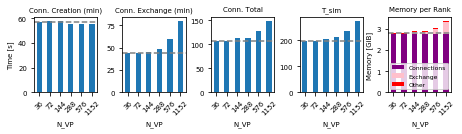

In [9]:
hpc_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_s20.csv')

hpc_t6_s20 = calculate_T_conn_and_memory(hpc_t6_s20)
hpc_t6_s20_p = plot_results(hpc_t6_s20, 'benchmark_figures/hpc_benchmark.pdf', plot_T_sim=True)

save_table_latex(hpc_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_table.txt')
hpc_t6_s20_p

## HPC static

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,50.06,40.72,96.19,1.930745,0.081221,0.088061
72,50.33,41.15,100.73,1.930745,0.143802,0.057013
144,50.72,43.03,103.35,1.930745,0.137170,0.053371
288,50.44,44.89,105.59,1.951579,0.340648,0.053383
576,50.19,55.00,115.00,1.993245,0.419607,0.053736
1152,49.61,76.85,136.27,1.993083,0.456283,0.054601


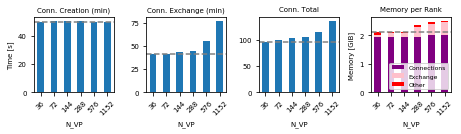

In [16]:
hpc_static_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_s20_static.csv')

hpc_static_t6_s20 = calculate_T_conn_and_memory(hpc_static_t6_s20)
hpc_static_t6_s20_p = plot_results(hpc_static_t6_s20, 'benchmark_figures/hpc_benchmark_static.pdf')

save_table_latex(hpc_static_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_table.txt')
hpc_static_t6_s20_p

## HPC delay 0.1 - 50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,62.20,49.81,119.08,2.743245,0.020511,0.051114
72,59.62,51.08,118.02,2.743245,0.035621,0.053351
144,59.59,59.08,126.80,2.743245,0.114220,0.053371
288,59.34,56.35,125.69,2.743245,0.171615,0.053383
576,59.15,71.34,144.99,2.743245,0.526704,0.053736
1152,58.13,86.20,159.43,2.743083,0.614377,0.054601


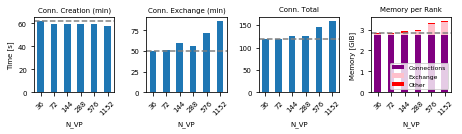

In [21]:
hpc_delay_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_s20_delays.csv')

hpc_delay_t6_s20 = calculate_T_conn_and_memory(hpc_delay_t6_s20)
hpc_delay_t6_s20_p = plot_results(hpc_delay_t6_s20, 'benchmark_figures/hpc_benchmark_diff_delays.pdf')

save_table_latex(hpc_delay_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_diff_delays_table.txt')
hpc_delay_t6_s20_p

## HPC static, delay 0.1-50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,54.94,44.56,104.89,1.930745,0.393721,0.051114
72,52.70,44.99,106.94,1.930745,0.393721,0.053351
144,53.21,45.86,105.42,1.930745,0.402876,0.053371
288,52.79,50.47,113.54,1.951579,0.457205,0.053383
576,52.55,61.31,123.59,1.993245,0.417980,0.053736
1152,52.62,84.25,146.82,1.993083,0.456120,0.054601


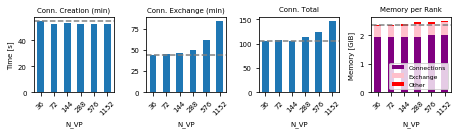

In [23]:
hpc_static_del_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_s20_static_delays.csv')

hpc_static_del_t6_s20 = calculate_T_conn_and_memory(hpc_static_del_t6_s20)
hpc_static_del_t6_s20_p = plot_results(hpc_static_del_t6_s20,
                                       'benchmark_figures/hpc_benchmark_static_diff_delays.pdf')

save_table_latex(hpc_static_del_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_diff_delays_table.txt')
hpc_static_del_t6_s20_p

## HPC Split into many `Connect` calls

Constant number of Connect calls

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,96.32,40.29,146.28,2.743245,0.020348,0.060066
72,97.72,41.39,147.60,2.743245,0.053850,0.104539
144,100.38,42.10,151.84,2.743245,0.103478,0.206529
288,105.15,45.54,162.25,2.743245,0.104503,0.442766
576,115.53,55.34,180.38,2.743245,0.178478,0.414810
1152,136.55,73.07,222.75,2.743083,0.545475,0.272529


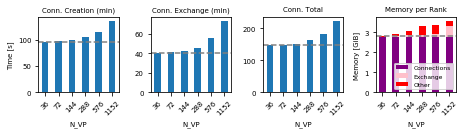

In [52]:
hpc_split_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_s20_split.csv')

hpc_split_t6_s20 = calculate_T_conn_and_memory(hpc_split_t6_s20)
hpc_split_t6_s20_p = plot_results(hpc_split_t6_s20, 'benchmark_figures/hpc_benchmark_split.pdf', plot_T_sim=False)

save_table_latex(hpc_split_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_table.txt')
hpc_split_t6_s20_p

## HPC split into many Connect calls, increasing number of NBLOCKS

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,94.99,39.99,142.62,2.743245,0.019534,0.058764
72,231.48,39.14,280.93,2.743245,0.026886,0.139045
144,752.86,39.27,853.67,2.826579,0.019941,0.219332
288,2731.34,41.79,3046.18,2.933350,0.120671,0.343998
576,NaN,NaN,NaN,NaN,NaN,NaN
1152,NaN,NaN,NaN,NaN,NaN,NaN


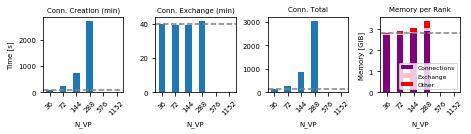

In [18]:
hpc_split_increase_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_s20_split_increase.csv')

hpc_split_increase_t6_s20 = calculate_T_conn_and_memory(hpc_split_increase_t6_s20)
hpc_split_increase_t6_s20_p = plot_results(hpc_split_increase_t6_s20,
                                           'benchmark_figures/hpc_benchmark_split_increase.pdf', plot_T_sim=False)

save_table_latex(hpc_split_increase_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_increase_table.txt')
hpc_split_increase_t6_s20_p

## Comparing different cases from above

Conn. Creation (min)                      Conn. Exchange (min)  \
Case              Default Random delay   Split              Default   
N_VP                                                                  
36                  57.50        62.20   96.32                43.84   
72                  57.56        59.62   97.72                43.86   
144                 57.99        59.59  100.38                45.32   
288                 55.84        59.34  105.15                48.59   
576                 55.30        59.15  115.53                59.38   
1152                55.61        58.13  136.55                79.83   

                         Conn. Total                      Memory per Rank  \
Case Random delay  Split     Default Random delay   Split         Default   
N_VP                                                                        
36          49.81  40.29      107.11       119.08  146.28        2.818777   
72          51.08  41.39      107.91       118.02  147.60        2.821014   
144         59.08  42.10      112.39       126.80  151.84        2.906890   
288         56.35  45.54      113.67       125.69  162.25        2.910795   
576         71.34  55.34      128.70       144.99  180.38        3.030879   
1152        86.20  73.07      149.05       159.43  222.75        3.383849   

                             
Case Random delay     Split  
N_VP                         
36       2.814871  2.823660  
72       2.832217  2.901635  
144      2.910837  3.053252  
288      2.968243  3.290515  
576      3.323685  3.336533  
1152     3.412061  3.561086

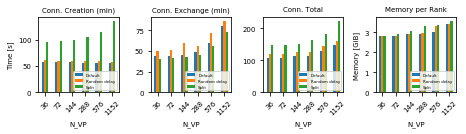

In [22]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_delay_t6_s20['Case'] = ['Random delay'] * len(hpc_delay_t6_s20)
hpc_split_t6_s20['Case'] = ['Split'] * len(hpc_split_t6_s20)

hpc_cases = pd.concat([hpc_t6_s20, hpc_delay_t6_s20, hpc_split_t6_s20])

hpc_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_cases.pdf')
save_table_latex(hpc_cases_p.to_latex(), 'latex_tables/hpc_cases_table.txt')

hpc_cases_p

## HPC many connections per neuron
For comparison with population model

Important:
- N_nrns ~ 500 000 * NUMBER_OF_NODES
- N_conns_sum ~ 2 500 000 000 * NUMBER_OF_NODES

0     2498000500
1     4996000000
2     9991999000
3    19983997000
4    39967993000
5    79935985000
Name: N_conns_sum, dtype: int64
0      499500
1      999000
2     1998000
3     3996000
4     7992000
5    15984000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,57.36,45.18,109.41,2.720052,0.052379,0.070727
72,56.14,46.17,115.53,2.720052,0.331924,0.073127
144,56.31,49.92,115.63,2.720052,0.171732,0.073146
288,55.51,60.63,125.13,2.720052,0.305987,0.073158
576,54.71,86.22,155.36,2.720052,0.667003,0.073512
1152,54.99,146.45,214.99,2.720052,0.779850,0.074213


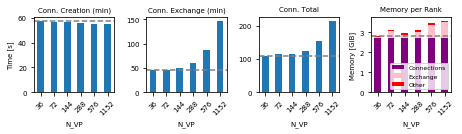

In [10]:
hpc_pop_comp = pd.read_csv('benchmark_results/hpc_pop_comp_benchmark_master_daint_t6_s44.csv')

hpc_pop_comp = calculate_T_conn_and_memory(hpc_pop_comp)

hpc_pop_comp_p = plot_results(hpc_pop_comp, 'benchmark_figures/hpc_benchmark_many_neurons.pdf')

save_table_latex(hpc_pop_comp_p.to_latex(), 'latex_tables/hpc_benchmark_many_neurons_table.txt')

print(hpc_pop_comp['N_conns_sum'])
print(hpc_pop_comp['N_nrns'])
hpc_pop_comp_p

## Population model

0     2500000000
1     5000000000
2    10000000000
3    20000000000
4    40000000000
5    80000000000
Name: N_conns_sum, dtype: int64
0      500000
1     1000000
2     2000000
3     4000000
4     8000000
5    16000000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,44.99,35.52,86.16,1.979818,0.084791,0.065193
72,45.52,35.82,87.20,1.975260,0.129061,0.071336
144,47.26,36.77,91.17,1.975260,0.214959,0.071356
288,49.82,39.59,94.78,1.975260,0.118175,0.071368
576,54.27,52.93,113.00,1.975260,0.398448,0.071721
1152,65.91,89.30,167.62,1.975260,0.450849,0.072423


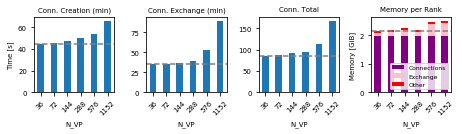

In [13]:
population = pd.read_csv('benchmark_results/population_model_master_daint_t6.csv')

population = calculate_T_conn_and_memory(population)
population_p = plot_results(population, 'benchmark_figures/population_model.pdf', plot_T_sim=False)

save_table_latex(population_p.to_latex(), 'latex_tables/population_model_table.txt')

print(population['N_conns_sum'])
print(population['N_nrns'])
population_p

## HPC benchmark vs HPC benchmark with many synapses per neuron

Conn. Creation (min)               Conn. Exchange (min)                \
Case              Default many synapses              Default many synapses   
N_VP                                                                         
36                  57.50         57.36                43.84         45.18   
72                  57.56         56.14                43.86         46.17   
144                 57.99         56.31                45.32         49.92   
288                 55.84         55.51                48.59         60.63   
576                 55.30         54.71                59.38         86.22   
1152                55.61         54.99                79.83        146.45   

     Conn. Total               Memory per Rank                
Case     Default many synapses         Default many synapses  
N_VP                                                          
36        107.11        109.41        2.818777      2.843158  
72        107.91        115.53        2.821014      3.125103  
144       112.39        115.63        2.906890      2.964931  
288       113.67        125.13        2.910795      3.099197  
576       128.70        155.36        3.030879      3.460567  
1152      149.05        214.99        3.383849      3.574116

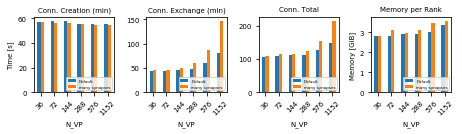

In [11]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_pop_comp['Case'] = ['many synapses'] * len(hpc_pop_comp)

hpc_cases = pd.concat([hpc_t6_s20, hpc_pop_comp])

hpc_synapse_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_synapse_cases.pdf')
save_table_latex(hpc_synapse_cases_p.to_latex(), 'latex_tables/hpc_synapse_cases_table.txt')

hpc_synapse_cases_p

#### time per connection

Conn. Creation Time per Conn. (min)                \
Case                             Default many synapses   
N_VP                                                     
36                             22.714021     22.962365   
72                             11.368864     11.236990   
144                             5.726898      5.635509   
288                             2.757286      2.777723   
576                             1.365311      1.368845   
1152                            0.686482      0.687925   

     Conn. Exchange Time per Conn. (min)                \
Case                             Default many synapses   
N_VP                                                     
36                             17.317960     18.086466   
72                              8.662932      9.241393   
144                             4.475651      4.995997   
288                             2.399293      3.033928   
576                             1.466042      2.157226   
1152                            0.985468      1.832091   

     Total Conn. Time per Conn.                
Case                    Default many synapses  
N_VP                                           
36                    42.311284     43.799030  
72                    21.313657     23.124500  
144                   11.099259     11.572259  
288                    5.612834      6.261510  
576                    3.177495      3.887110  
1152                   1.839960      2.689527

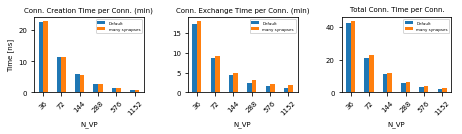

In [12]:
hpc_cases = time_per_connection(hpc_cases)
values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_synapse_cases_tpc__p = plot_compare(hpc_cases, 'benchmark_figures/hpc_synapse_cases_time_per_conn.pdf',
                                        values, legend_loc='upper right')
save_table_latex(hpc_synapse_cases_tpc__p.to_latex(), 'latex_tables/hpc_synapse_cases_time_per_conn_table.txt')

hpc_synapse_cases_tpc__p

## HPC benchmark with many synapses per neuron vs block Population model

Conn. Creation (min)            Conn. Exchange (min)             \
Case        many synapses population        many synapses population   
N_VP                                                                   
36                  57.36      44.99                45.18      35.52   
72                  56.14      45.52                46.17      35.82   
144                 56.31      47.26                49.92      36.77   
288                 55.51      49.82                60.63      39.59   
576                 54.71      54.27                86.22      52.93   
1152                54.99      65.91               146.45      89.30   

       Conn. Total            Memory per Rank             
Case many synapses population   many synapses population  
N_VP                                                      
36          109.41      86.16        2.843158   2.129802  
72          115.53      87.20        3.125103   2.175658  
144         115.63      91.17        2.964931   2.261575  
288         125.13      94.78        3.099197   2.164803  
576         155.36     113.00        3.460567   2.445430  
1152        214.99     167.62        3.574116   2.498532

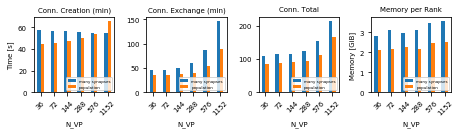

In [14]:
population['Case'] = ['population'] * len(population)

hpc_synapse_pop_cases = pd.concat([hpc_pop_comp, population])

hpc_synapse_pop_cases_p = plot_compare(hpc_synapse_pop_cases, 'benchmark_figures/hpc_synapse_vs_pop_cases.pdf')
save_table_latex(hpc_synapse_pop_cases_p.to_latex(), 'latex_tables/hpc_synapse_vs_pop_cases_table.txt')

hpc_synapse_pop_cases_p

#### time per connection

Conn. Creation Time per Conn. (min)             \
Case                       many synapses population   
N_VP                                                  
36                             22.962365  17.996000   
72                             11.236990   9.104000   
144                             5.635509   4.726000   
288                             2.777723   2.491000   
576                             1.368845   1.356750   
1152                            0.687925   0.823875   

     Conn. Exchange Time per Conn. (min)             \
Case                       many synapses population   
N_VP                                                  
36                             18.086466   14.20800   
72                              9.241393    7.16400   
144                             4.995997    3.67700   
288                             3.033928    1.97950   
576                             2.157226    1.32325   
1152                            1.832091    1.11625   

     Total Conn. Time per Conn.             
Case              many synapses population  
N_VP                                        
36                    43.799030   34.46400  
72                    23.124500   17.44000  
144                   11.572259    9.11700  
288                    6.261510    4.73900  
576                    3.887110    2.82500  
1152                   2.689527    2.09525

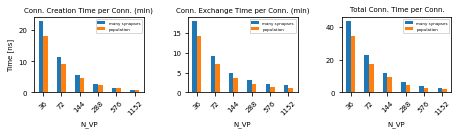

In [15]:
hpc_synapse_pop_cases = time_per_connection(hpc_synapse_pop_cases)
values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_synapse_pop_tpc_cases_p = plot_compare(hpc_synapse_pop_cases,
                                           'benchmark_figures/hpc_synapse_vs_pop_cases_time_per_conn.pdf',
                                           values, legend_loc='upper right')
save_table_latex(hpc_synapse_pop_tpc_cases_p.to_latex(),
                 'latex_tables/hpc_synapse_vs_pop_cases_time_per_conn_table.txt')

hpc_synapse_pop_tpc_cases_p

## Compare nblocks and population

Conn. Creation Time per Conn. (min)                                \
Case                             NBLOCKS increasing NBLOCKS population   
N_VP                                                                     
36                             37.183821          37.183821  17.700000   
72                             18.853772          45.938216   8.886000   
144                             9.694696          77.503129   4.616000   
288                             5.081434         146.605880   2.424500   
576                             2.790176                NaN   1.334000   
1152                            1.652979                NaN   0.807125   

     Conn. Exchange Time per Conn. (min)                                \
Case                             NBLOCKS increasing NBLOCKS population   
N_VP                                                                     
36                             17.358005          17.262784   15.83200   
72                              8.744468           8.637345    8.10000   
144                             4.526969           4.388076    4.14600   
288                             2.421195           2.364396    2.18750   
576                             1.431292                NaN    1.35125   
1152                            0.962378                NaN    1.20925   

     Total Conn. Time per Conn.                                
Case                    NBLOCKS increasing NBLOCKS population  
N_VP                                                           
36                    55.819375          56.120909    34.7080  
72                    28.159648          57.505593    17.7200  
144                   14.793984          87.183434     9.1950  
288                    7.938066         166.895246     4.7665  
576                    4.422573                NaN     2.7700  
1152                   2.720248                NaN     2.1535

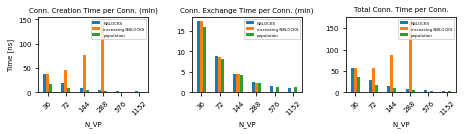

In [108]:
hpc_split_t6_s20['Case']          = ['NBLOCKS']*len(hpc_split_t6_s20)
hpc_split_increase_t6_s20['Case'] = ['increasing NBLOCKS']*len(hpc_split_increase_t6_s20)
population['Case']                = ['population']*len(population)

increasing_conns = pd.concat([hpc_split_t6_s20, hpc_split_increase_t6_s20, population])

increasing_conns = time_per_connection(increasing_conns)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

increasing_conns_p = plot_compare(increasing_conns, 'benchmark_figures/nblocks_vs_population.pdf',
                                  values=values, legend_loc='upper right')
save_table_latex(increasing_conns_p.to_latex(), 'latex_tables/nblocks_vs_population.txt')

increasing_conns_p

## Multi-Area Model

0     258258
1     516391
2    1032643
3    2065151
4    4130180
5    8260234
Name: N_nrns, dtype: int64
0     1508419407
1     3016843251
2     6033690822
3    12067386057
4    24134776576
5    48269557645
Name: N_conns_sum, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,115.540955,36.773965,152.315460,2.550357,0.064022,-1.942890e-16
72,157.707207,37.471828,195.180027,2.552377,0.070234,1.532661e-02
144,239.481476,39.335981,278.818017,2.553698,0.179664,5.411784e-03
288,404.558178,43.006161,447.565208,2.625976,0.254161,1.110223e-16
576,727.085242,36.457738,763.544337,2.677596,0.105154,3.885781e-16
1152,1432.082026,62.643363,1494.728333,2.939559,0.445765,-3.330669e-16


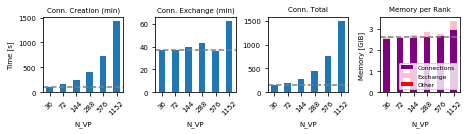

In [44]:
MAM_t6_s0_0625 = pd.read_csv('benchmark_results/MAM_master_daint_t6_s0_0625.csv')

MAM_t6_s0_0625['T_conns_min'] = MAM_t6_s0_0625['T_network_global_min'] + MAM_t6_s0_0625['T_connect_min']
MAM_t6_s0_0625['T_conns_max'] = MAM_t6_s0_0625['T_network_global_max'] + MAM_t6_s0_0625['T_connect_max']

MAM_t6_s0_0625 = calculate_T_conn_and_memory(MAM_t6_s0_0625)
MAM_t6_s0_0625_p = plot_results(MAM_t6_s0_0625, 'benchmark_figures/multi-area-model.pdf', plot_T_sim=False)

save_table_latex(MAM_t6_s0_0625_p.to_latex(), 'latex_tables/multi-area-model_table.txt')

print(MAM_t6_s0_0625.N_nrns)
print(MAM_t6_s0_0625.N_conns_sum)
MAM_t6_s0_0625_p

## 4x4 mesocircuit

0      77169
1     154338
2     308676
3     617352
4    1234704
5    2469408
Name: N_nrns, dtype: int64
0      345443323
1      690927633
2     1381963143
3     2763938640
4     5527888387
5    11055874121
Name: N_conns_sum, dtype: int64


,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,SCALE,NUM_VPS,hash,num_tasks,T_nrns,T_conns_avg,T_conns_min,...,T_bld_xn,T_bld_nx,Conn. Total,Conn. Creation (min),Conn. Exchange (min),N_VP,connections,ini,other,Memory per Rank
0,1,6,6,0.0625,36,acd429db3b9ab17b5f5391184e500dc6,6,0.82,158.551667,158.27,...,164.40,164.76,164.40,158.27,6.13,36,0.500407,0.119683,0.051769,0.671859
1,2,6,6,0.1250,72,acd429db3b9ab17b5f5391184e500dc6,12,1.31,193.479167,193.28,...,200.23,200.77,200.23,193.28,6.94,72,0.519694,0.105143,0.066050,0.690887
2,4,6,6,0.2500,144,acd429db3b9ab17b5f5391184e500dc6,24,1.62,225.032500,224.53,...,231.93,232.79,231.93,224.53,7.40,144,0.538167,0.124919,0.077788,0.740874
3,8,6,6,0.5000,288,acd429db3b9ab17b5f5391184e500dc6,48,3.86,330.748750,330.28,...,338.49,339.49,338.49,330.28,8.19,288,0.453717,0.177225,0.105143,0.736085
4,16,6,6,1.0000,576,acd429db3b9ab17b5f5391184e500dc6,96,7.20,516.553437,516.21,...,527.19,528.25,527.19,516.21,10.95,576,0.407391,0.232835,0.173206,0.813431
5,32,6,6,2.0000,1152,acd429db3b9ab17b5f5391184e500dc6,192,20.87,935.660156,934.87,...,949.49,951.61,949.49,934.87,14.55,1152,0.408836,0.364910,0.305743,1.079489


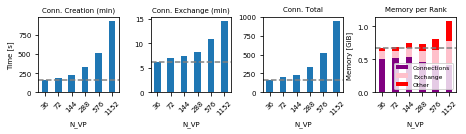

In [25]:
meso_t6_s0_0625 = pd.read_csv('benchmark_results/4x4_mesocircuit_daint_t6_s0_0625.csv')

meso_t6_s0_0625 = calculate_T_conn_and_memory(meso_t6_s0_0625)
meso_t6_s0_0625_p = plot_results(meso_t6_s0_0625, 'benchmark_figures/mesocircuit.pdf', plot_T_sim=False)

save_table_latex(meso_t6_s0_0625_p.to_latex(), 'latex_tables/mesocircuit_table.txt')

print(meso_t6_s0_0625.N_nrns)
print(meso_t6_s0_0625.N_conns_sum)
meso_t6_s0_0625

## Comapare hpc, population, MAM and 4x4

Conn. Creation Time per Conn. (min)                                   \
Case                                 4x4        MAM        hpc population   
N_VP                                                                        
36                            458.164884  76.597367  22.714021  17.996000   
72                            279.739861  52.275572  11.368864   9.104000   
144                           162.471772  39.690711   5.726898   4.726000   
288                           119.496140  33.524922   2.757286   2.491000   
576                            93.382855  30.126040   1.365311   1.356750   
1152                           84.558669  29.668431   0.686482   0.823875   

     Conn. Exchange Time per Conn. (min)                                   \
Case                                 4x4        MAM        hpc population   
N_VP                                                                        
36                             17.745313  24.379138  17.317960   14.20800   
72                             10.044467  12.420873   8.662932    7.16400   
144                             5.354701   6.519390   4.475651    3.67700   
288                             2.963163   3.563834   2.399293    1.97950   
576                             1.980865   1.510589   1.466042    1.32325   
1152                            1.316042   1.297782   0.985468    1.11625   

     Total Conn. Time per Conn.                                    
Case                        4x4         MAM        hpc population  
N_VP                                                               
36                   475.910197  100.976863  42.311284   34.46400  
72                   289.798802   64.696774  21.313657   17.44000  
144                  167.826473   46.210193  11.099259    9.11700  
288                  122.466539   37.088828   5.612834    4.73900  
576                   95.369147   31.636686   3.177495    2.82500  
1152                  85.881043   30.966274   1.839960    2.09525

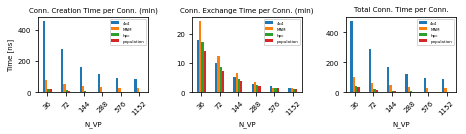

In [45]:
hpc_t6_s20['Case']      = ['hpc']*len(hpc_t6_s20)
MAM_t6_s0_0625['Case']  = ['MAM']*len(MAM_t6_s0_0625)
meso_t6_s0_0625['Case'] = ['4x4']*len(meso_t6_s0_0625)
population['Case']      = ['population']*len(population)

hpc_pop_MAM_4x4 = pd.concat([hpc_t6_s20, population, MAM_t6_s0_0625, meso_t6_s0_0625])

hpc_pop_MAM_4x4 = time_per_connection(hpc_pop_MAM_4x4)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_pop_MAM_4x4_p = plot_compare(hpc_pop_MAM_4x4, 'benchmark_figures/hpc_population_MAM_4x4.pdf',
                                 values=values, legend_loc='upper right')
save_table_latex(hpc_pop_MAM_4x4_p.to_latex(), 'latex_tables/hpc_population_MAM_4x4_table.txt')

hpc_pop_MAM_4x4_p

## Different `Connect` rules
Compare different connection rules, `SCALE = 5 * NUMBER_OF_NODES`

**Compare *all* rules:**

Conn. Creation Time per Conn. (min)                                 \
Case                          all to all fixed indegree fixed outdegree   
N_VP                                                                      
36                             20.854893      21.519069      113.971765   
72                             10.033597      10.973831       94.047538   
144                             5.036803       5.561973       84.624800   
288                             2.513523       2.711857       79.634580   
576                             1.250603       1.349016       77.054508   
1152                            0.617281       0.677471       75.733246   

                                                                         \
Case fixed total number pairwise bernoulli symmetric pairwise bernoulli   
N_VP                                                                      
36         7.442840e+05          28.853987                   357.811216   
72         1.479475e+06          14.395081                   360.724409   
144        1.351044e+06           8.990872                   483.808023   
288        1.161326e+06           6.251307                   741.284377   
576        9.022359e+05           4.903183                          NaN   
1152       6.240533e+05           4.219885                          NaN   

     Conn. Exchange Time per Conn. (min)                                 \
Case                          all to all fixed indegree fixed outdegree   
N_VP                                                                      
36                             18.327027      18.643540       14.777990   
72                              9.796583       8.982898       28.947982   
144                             5.175068       4.641561       15.688149   
288                             2.246863       2.646678        8.538293   
576                             1.158012       1.367780        4.699039   
1152                            0.529627       0.773265        2.683920   

                                                                         \
Case fixed total number pairwise bernoulli symmetric pairwise bernoulli   
N_VP                                                                      
36           193.626462          18.266817                    67.966436   
72           137.262818           8.430050                    39.802220   
144          118.430792           4.428281                    22.057888   
288          298.223350           2.397816                    11.601888   
576          133.267522           1.322329                          NaN   
1152         365.686945           0.744134                          NaN   

     Total Conn. Time per Conn.                                 \
Case                 all to all fixed indegree fixed outdegree   
N_VP                                                             
36                    44.869617      47.019640      131.259225   
72                    22.121316      22.911526      135.346195   
144                   11.219232      11.665131      104.007696   
288                    5.348027       6.269071       97.229651   
576                    2.703673       3.146387       88.195391   
1152                   1.295054       1.663556       82.319235   

                                                                         
Case fixed total number pairwise bernoulli symmetric pairwise bernoulli  
N_VP                                                                     
36         7.620169e+05          50.249550                   430.517293  
72         1.527235e+06          24.650194                   404.342523  
144        1.403190e+06          14.584490                   510.641697  
288        1.195159e+06           9.184385                   757.877407  
576        9.337907e+05           6.654109                          NaN  
1152       6.514457e+05           5.393611                          NaN

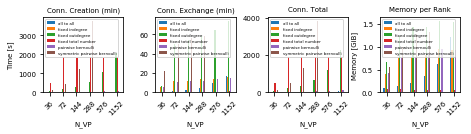

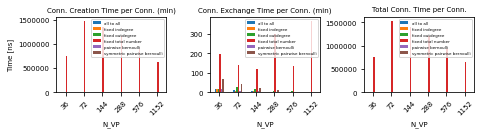

In [47]:
hpc_in = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_in.csv')
hpc_in['Case'] = ['fixed indegree']*len(hpc_in)

hpc_out = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_out.csv')
hpc_out['Case'] = ['fixed outdegree']*len(hpc_out)

hpc_all = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_all.csv')
hpc_all['Case'] = ['all to all']*len(hpc_all)

hpc_tot = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_tot.csv')
hpc_tot['Case'] = ['fixed total number']*len(hpc_tot)

hpc_bern = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_bern.csv')
hpc_bern['Case'] = ['pairwise bernoulli']*len(hpc_bern)

hpc_sym = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_t6_sym_bern.csv')
hpc_sym['Case'] = ['symmetric pairwise bernoulli']*len(hpc_sym)

hpc_rules = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_tot, hpc_out, hpc_sym])

hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules = time_per_connection(hpc_rules)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all.pdf', legend_loc='upper left')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_table.txt')
hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all_time_per_connection.pdf',
                           values, legend_loc='upper right')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_time_per_connection_table.txt')

hpc_rules_p

**Not including `fixed total number`:**

Conn. Creation Time per Conn. (min)                                 \
Case                          all to all fixed indegree fixed outdegree   
N_VP                                                                      
36                             20.854893      21.519069      113.971765   
72                             10.033597      10.973831       94.047538   
144                             5.036803       5.561973       84.624800   
288                             2.513523       2.711857       79.634580   
576                             1.250603       1.349016       77.054508   
1152                            0.617281       0.677471       75.733246   

                                                      \
Case pairwise bernoulli symmetric pairwise bernoulli   
N_VP                                                   
36            28.853987                   357.811216   
72            14.395081                   360.724409   
144            8.990872                   483.808023   
288            6.251307                   741.284377   
576            4.903183                          NaN   
1152           4.219885                          NaN   

     Conn. Exchange Time per Conn. (min)                                 \
Case                          all to all fixed indegree fixed outdegree   
N_VP                                                                      
36                             18.327027      18.643540       14.777990   
72                              9.796583       8.982898       28.947982   
144                             5.175068       4.641561       15.688149   
288                             2.246863       2.646678        8.538293   
576                             1.158012       1.367780        4.699039   
1152                            0.529627       0.773265        2.683920   

                                                      \
Case pairwise bernoulli symmetric pairwise bernoulli   
N_VP                                                   
36            18.266817                    67.966436   
72             8.430050                    39.802220   
144            4.428281                    22.057888   
288            2.397816                    11.601888   
576            1.322329                          NaN   
1152           0.744134                          NaN   

     Total Conn. Time per Conn.                                 \
Case                 all to all fixed indegree fixed outdegree   
N_VP                                                             
36                    44.869617      47.019640      131.259225   
72                    22.121316      22.911526      135.346195   
144                   11.219232      11.665131      104.007696   
288                    5.348027       6.269071       97.229651   
576                    2.703673       3.146387       88.195391   
1152                   1.295054       1.663556       82.319235   

                                                      
Case pairwise bernoulli symmetric pairwise bernoulli  
N_VP                                                  
36            50.249550                   430.517293  
72            24.650194                   404.342523  
144           14.584490                   510.641697  
288            9.184385                   757.877407  
576            6.654109                          NaN  
1152           5.393611                          NaN

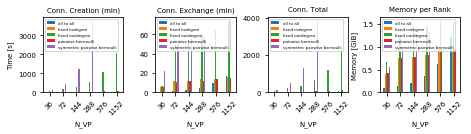

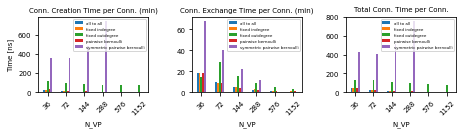

In [48]:
hpc_rules_no_tot = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_out, hpc_sym])

hpc_rules_no_tot = calculate_T_conn_and_memory(hpc_rules_no_tot)
hpc_rules_no_tot = time_per_connection(hpc_rules_no_tot)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_rules_no_tot_p = plot_compare(hpc_rules_no_tot, 'benchmark_figures/hpc_rules_no_tot.pdf',
                               legend_loc='upper left')
save_table_latex(hpc_rules_no_tot_p.to_latex(), 'latex_tables/hpc_rules_no_tot_table.txt')
hpc_rules_no_tot_p = plot_compare(hpc_rules_no_tot, 'benchmark_figures/hpc_rules_not_tot_time_per_connection.pdf',
                               values, legend_loc='upper right')
save_table_latex(hpc_rules_no_tot_p.to_latex(), 'latex_tables/hpc_rules_no_tot_time_per_connection_table.txt')

hpc_rules_no_tot_p

**Compare *fixed_indegree, pairwise_bernoulli, all_to_all*:**

Conn. Creation Time per Conn. (min)                                 \
Case                          all to all fixed indegree fixed outdegree   
N_VP                                                                      
36                             20.854893      21.519069      113.971765   
72                             10.033597      10.973831       94.047538   
144                             5.036803       5.561973       84.624800   
288                             2.513523       2.711857       79.634580   
576                             1.250603       1.349016       77.054508   
1152                            0.617281       0.677471       75.733246   

                        Conn. Exchange Time per Conn. (min)                 \
Case pairwise bernoulli                          all to all fixed indegree   
N_VP                                                                         
36            28.853987                           18.327027      18.643540   
72            14.395081                            9.796583       8.982898   
144            8.990872                            5.175068       4.641561   
288            6.251307                            2.246863       2.646678   
576            4.903183                            1.158012       1.367780   
1152           4.219885                            0.529627       0.773265   

                                        Total Conn. Time per Conn.  \
Case fixed outdegree pairwise bernoulli                 all to all   
N_VP                                                                 
36         14.777990          18.266817                  44.869617   
72         28.947982           8.430050                  22.121316   
144        15.688149           4.428281                  11.219232   
288         8.538293           2.397816                   5.348027   
576         4.699039           1.322329                   2.703673   
1152        2.683920           0.744134                   1.295054   

                                                        
Case fixed indegree fixed outdegree pairwise bernoulli  
N_VP                                                    
36        47.019640      131.259225          50.249550  
72        22.911526      135.346195          24.650194  
144       11.665131      104.007696          14.584490  
288        6.269071       97.229651           9.184385  
576        3.146387       88.195391           6.654109  
1152       1.663556       82.319235           5.393611

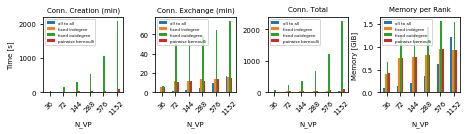

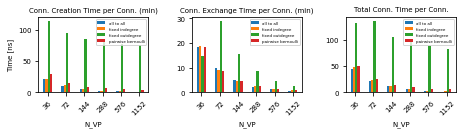

In [49]:
hpc_rules_few = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_out])

hpc_rules_few = calculate_T_conn_and_memory(hpc_rules_few)
hpc_rules_few = time_per_connection(hpc_rules_few)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_rules_few_p = plot_compare(hpc_rules_few, 'benchmark_figures/hpc_rules_fewer.pdf',
                               legend_loc='upper left')
save_table_latex(hpc_rules_few_p.to_latex(), 'latex_tables/hpc_rules_fewer_table.txt')
hpc_rules_few_p = plot_compare(hpc_rules_few, 'benchmark_figures/hpc_rules_fewer_time_per_connection.pdf',
                               values, legend_loc='upper right')
save_table_latex(hpc_rules_few_p.to_latex(), 'latex_tables/hpc_rules_fewer_time_per_connection_table.txt')

hpc_rules_few_p

## Fixed VP, different threads.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
Threads,,,,,,
1,24.65,15.33,41.37,2.724609,0.234478,0.395554
3,41.83,32.97,82.25,2.743164,0.053071,0.100922
6,57.43,42.98,106.25,2.743245,0.021976,0.055183
9,59.84,60.65,126.40,2.742622,0.011210,0.044476
18,75.64,92.34,173.75,2.746012,0.046535,0.032132
36,97.69,105.14,202.83,2.759644,0.013889,0.026956


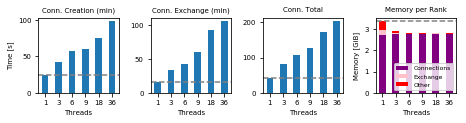

In [10]:
hpc_threads_n1 = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_s20_threads.csv')

hpc_threads_n1 = calculate_T_conn_and_memory(hpc_threads_n1)

hpc_threads_n1['Threads'] = hpc_threads_n1['THREADS_PER_TASK']

hpc_threads_n1_p = plot_results(hpc_threads_n1, 'benchmark_figures/hpc_fixedVP_diff_threads_n1.pdf',
                                index='Threads', rot=0)

save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n1_table.txt')
hpc_threads_n1_p

Conn. Creation (min)                       Conn. Exchange (min)  \
Case                    2.14   2.16     5g  master                 2.14   
Threads                                                                   
1                      48.96  27.32  20.58   26.59                 0.74   
3                      65.72  50.17  35.65   44.50                 1.14   
6                      71.94    NaN  46.75   58.02                 1.32   
9                      73.45    NaN  50.20   60.08                 1.18   
18                     75.75    NaN  63.14   76.86                 1.27   
36                     89.67    NaN  84.79  100.01                 1.88   

                               Conn. Total                         \
Case      2.16      5g  master        2.14   2.16      5g  master   
Threads                                                             
1        24.94   25.37   14.96       51.68  53.08   47.37   42.41   
3        39.65   32.34   33.05       72.07  96.38   73.83   85.81   
6          NaN   43.40   42.33       78.79    NaN   91.08  106.22   
9          NaN   46.54   64.84       77.40    NaN   97.98  130.10   
18         NaN   64.40   92.64       79.30    NaN  129.18  173.03   
36         NaN  134.14  104.20       91.55    NaN  218.93  204.21   

        Memory per Rank                                
Case               2.14      2.16        5g    master  
Threads                                                
1              3.131454  4.883400  4.381996  3.354645  
3              2.838875  4.413905  3.916854  2.901877  
6              2.796472       NaN  3.829361  2.817963  
9              2.787800       NaN  3.809237  2.797168  
18             2.778902       NaN  3.789648  2.810139  
36             2.786571       NaN  3.783141  2.800488

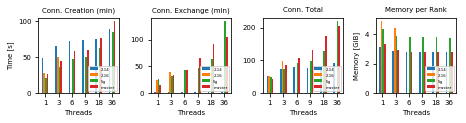

In [11]:
hpc_threads_214 = pd.read_csv('benchmark_results/hpc_benchmark_214_daint_threads.csv')
hpc_threads_214['Case'] = ['2.14']*len(hpc_threads_214)
hpc_threads_216 = pd.read_csv('benchmark_results/hpc_benchmark_216_daint_threads.csv')
hpc_threads_216['Case'] = ['2.16']*len(hpc_threads_216)
hpc_threads_m   = pd.read_csv('benchmark_results/hpc_benchmark_master_daint_threads.csv')
hpc_threads_m['Case']   = ['master']*len(hpc_threads_m)
hpc_threads_5g  = pd.read_csv('benchmark_results/hpc_benchmark_5g_daint_threads.csv')
hpc_threads_5g['Case']  = ['5g']*len(hpc_threads_5g)
# hpc_threads_3   = pd.read_csv('benchmark_results/hpc_benchmark_3_daint_threads.csv')
# hpc_threads_3['version']   = ['3']*len(hpc_threaDs_3)

hpc_threads = pd.concat([hpc_threads_214, hpc_threads_216, hpc_threads_m, hpc_threads_5g])

hpc_threads = calculate_T_conn_and_memory(hpc_threads)
hpc_threads['Threads'] = hpc_threads['THREADS_PER_TASK']
hpc_threads_p = plot_compare(hpc_threads, 'benchmark_figures/hpc_fixedVP_diff_threads_comparison.pdf',
                             index='Threads', rot=0)
save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_comparison.txt')

hpc_threads_p